## Gender Based Violence - Tweet classification challenge 

This challenge aims to classify tweets about GBV without using keywords.

Are you able to develop a machine learning model that can classify a tweet about gender-based violence into either of the five categories:
- Sexual violence
- Emotional violence
- Economic violence
- Physical violence
- Harmful traditional practice


### import libraries/modules

In [1]:
!pip install tensorflow-text --quiet

     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [2]:
!pip install -q tf-models-official --quiet

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 35.4 MB/s 
     |████████████████████████████████| 213 kB 45.5 MB/s 
     |████████████████████████████████| 47.6 MB 1.5 MB/s 
     |████████████████████████████████| 596 kB 53.2 MB/s 
     |████████████████████████████████| 1.1 MB 40.4 MB/s 
     |████████████████████████████████| 352 kB 31.9 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 99 kB 7.8 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import spacy
import time 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from official.nlp import optimization  # to create AdamW optimizer


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Model
import tensorflow_hub as hub

In [42]:
np.random.seed(1)
tf.random.set_seed(123)

### load the dataset

In [43]:
train = pd.read_csv("https://raw.githubusercontent.com/Josepholaidepetro/Gender-Based-Violence-Tweet-Classification-Challenge/main/data/Train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/Josepholaidepetro/Gender-Based-Violence-Tweet-Classification-Challenge/main/data/Test.csv")
sub = pd.read_csv('https://raw.githubusercontent.com/Josepholaidepetro/UN-Tweety-Goal-5/main/data/SampleSubmission.csv')

In [44]:
test.head()

,Tweet_ID,tweet
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,..."
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l..."
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...
3,ID_00G9OSKZ,University of Cape Coast students being robbed...
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i..."


### EDA

In [45]:
train.shape # the training dataset has 39650 rows

(39650, 3)

In [46]:
train["type"].unique()

array(['sexual_violence', 'Physical_violence', 'emotional_violence',
       'Harmful_Traditional_practice', 'economic_violence'], dtype=object)

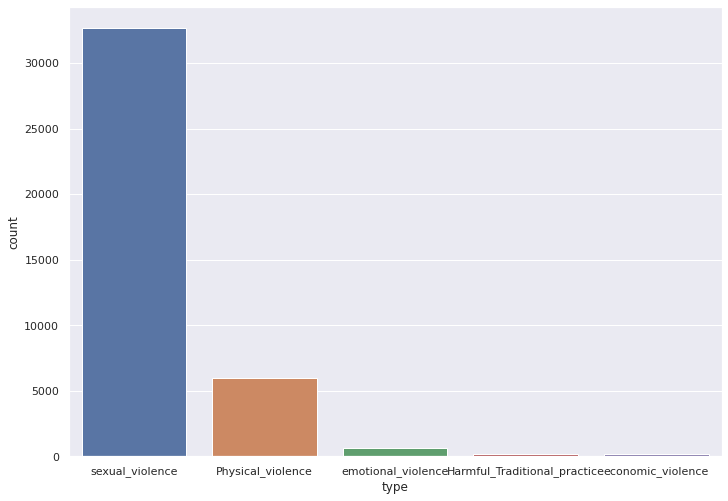

In [47]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.countplot(x=train["type"])

This dataset is highly imbalanced; from the graphs above, sexual violence is about 80%+. 

In [48]:
test.shape # the test dataset has 15581 rows

(15581, 2)

In [49]:
X = train['tweet'].values
y = train["type"]

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()        
y = le.fit_transform(y)

In [53]:
train_df = pd.DataFrame(X, columns=['tweet'])
train_df['type'] = y

# Bert

In [73]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [74]:
def make_dataset(texts, labels):
  AUTOTUNE = tf.data.AUTOTUNE
  texts = list(texts)
  labels = list(labels)
  dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
  dataset = dataset.batch(64)
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [75]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.8)(net)
  net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [76]:
"""# creating class weights to reduce class imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights"""

'# creating class weights to reduce class imbalance\nfrom sklearn.utils import class_weight\nclass_weights = class_weight.compute_class_weight(\n                                        class_weight = "balanced",\n                                        classes = np.unique(y_train),\n                                        y = y_train                                                    \n                                    )\nclass_weights = dict(zip(np.unique(y_train), class_weights))\nclass_weights'

In [77]:
target = 'type'
features = [c for c in train_df.columns if c not in ['type']]
k = 4
kf = StratifiedKFold(k)

In [80]:
classifier_model = build_classifier_model()
test_texts = [pair for pair in test['tweet']]
preds = []

for i, (tr_idx, vr_idx) in enumerate(kf.split(train_df, train_df[target])):

    xtrain, ytrain = train_df.loc[tr_idx, features], train_df.loc[tr_idx, target]
    xval, yval = train_df.loc[vr_idx, features], train_df.loc[vr_idx, target]

    train_ds = make_dataset(xtrain['tweet'], ytrain)
    val_ds = make_dataset(xval['tweet'], yval )

    epochs = 3
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 5e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
    
    classifier_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    print(f'Training model with {tfhub_handle_encoder}')
    classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)
    
    ss = classifier_model.predict(test_texts)
    preds.append(ss)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/3
465/465 [==============================] - 215s 454ms/step - loss: 0.5731 - accuracy: 0.8427 - val_loss: 0.0627 - val_accuracy: 0.9804
Epoch 2/3
465/465 [==============================] - 211s 454ms/step - loss: 0.0683 - accuracy: 0.9823 - val_loss: 0.0287 - val_accuracy: 0.9923
Epoch 3/3
465/465 [==============================] - 211s 455ms/step - loss: 0.0407 - accuracy: 0.9889 - val_loss: 0.0226 - val_accuracy: 0.9948
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/3
465/465 [==============================] - 211s 448ms/step - loss: 0.0293 - accuracy: 0.9930 - val_loss: 0.0080 - val_accuracy: 0.9983
Epoch 2/3
465/465 [==============================] - 209s 449ms/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 3/3
465/465 [==============================] - 209s 450ms/step - loss: 0.0101 - accur

In [164]:
ss = np.mean(preds, axis=0)

In [165]:
ss = pd.DataFrame(np.mean(preds, axis=0))

In [168]:
ss.shape

(15581, 5)

In [169]:
pred = [np.argmax(i) for i in ss.values]

In [170]:
final = le.inverse_transform(pred)

In [171]:
sub['type'] = final

In [172]:
sub['type'].value_counts()

sexual_violence                 10966
Harmful_Traditional_practice     2280
Physical_violence                1227
emotional_violence                666
economic_violence                 442
Name: type, dtype: int64

In [173]:
sub['type'].value_counts()

sexual_violence                 10966
Harmful_Traditional_practice     2280
Physical_violence                1227
emotional_violence                666
economic_violence                 442
Name: type, dtype: int64